# Advanced Programming for Business Analytics  
Name: Niranjan Krishnan Devaraj

## Objective: To create a model which can predict the popularity of a song based on different algorithms

In [1]:
#Importing necessary libraries for this task
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

In [2]:
# Load the dataset
df = pd.read_csv("spotify-dataset.csv")

In [3]:
# Remove rows with NaN values
df.dropna(inplace=True)

Since the artist names proved hard to handle due to its dimensionality, and the fact that a name doesn't intrinsically provide any value, I've categorised it by grouping artists based on their popularity score, and assigning artists the mean popularity score of their songs. The category is then divided into 3 groups which are then one hot encoded

In [4]:
# Calculate average popularity score for each artist
artist_popularity = df.groupby('artists')['popularity'].mean()

In [5]:
# Define popularity thresholds for categorization
low_threshold = artist_popularity.quantile(0.33)
high_threshold = artist_popularity.quantile(0.66)

# Categorize artists based on average popularity score
def categorize_popularity(popularity):
    if popularity < low_threshold:
        return 'low'
    elif popularity < high_threshold:
        return 'mid'
    else:
        return 'high'

artist_popularity_category = artist_popularity.apply(categorize_popularity)

In [6]:
# Merge popularity category back into the original dataframe
df = df.merge(artist_popularity_category, left_on='artists', right_index=True, how='left')

In [7]:
# Drop irrelevant columns
df.drop(columns=['track_id', 'album_name', 'track_name','artists'], inplace=True)

In [8]:
# Function to remove outliers using IQR method
def remove_outliers(df):
    """
    Remove outliers from numerical columns in the DataFrame using IQR method.
    """
    # Copy the DataFrame to avoid modifying the original
    df_cleaned = df.copy()
    
    # Iterate over each numerical column
    for column in df_cleaned.select_dtypes(include=['number']):
        # Calculate quartiles and IQR
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define threshold for outlier detection
        threshold = 1.5
        
        # Determine outliers
        outliers = ((df_cleaned[column] < (Q1 - threshold * IQR)) | (df_cleaned[column] > (Q3 + threshold * IQR)))
        
        # Remove outliers
        df_cleaned = df_cleaned[~outliers]
    
    return df_cleaned

# Remove outliers
df_cleaned = remove_outliers(df)

In [9]:
# One-hot encode categorical features
df_cleaned = pd.get_dummies(df_cleaned, columns=['track_genre','explicit','key','mode','time_signature'])

In [10]:
# One-hot encode the popularity category
df_cleaned = pd.get_dummies(df_cleaned, columns=['popularity_y'])

In [11]:
# Split features and target variable
X = df_cleaned.drop(columns=['popularity_x'])
Y = df_cleaned['popularity_x']

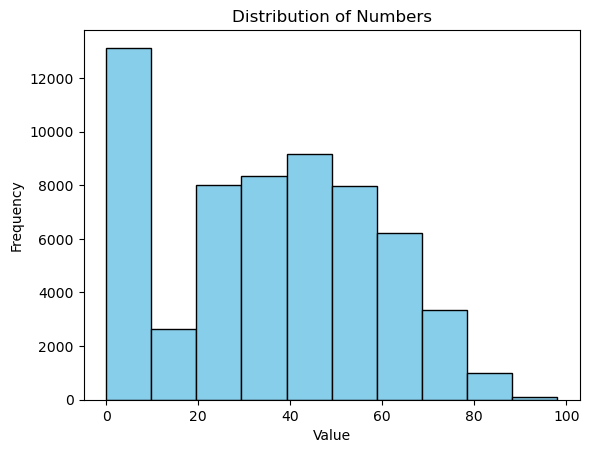

In [12]:
plt.hist(Y, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')
plt.show()

Even after outlier treatment and removal of NaN values, the distribution is significantly concentrated in the 0 - 10 popularity score zone, which might affect the models we'll be running. Hence, I'm removing the data points to normalize the data distribution

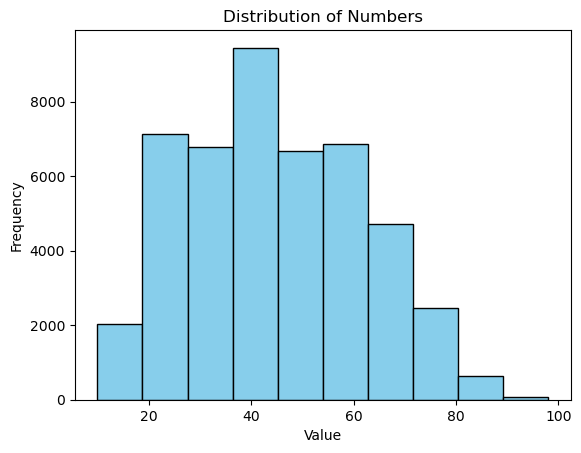

In [13]:
filtered_df = df_cleaned[df_cleaned['popularity_x'] >= 10]

# Split features and target variable
X = filtered_df.drop(columns=['popularity_x'])
Y = filtered_df['popularity_x']

plt.hist(Y, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')
plt.show()

The data now shows a normal distribution, and is ready for modelling

In [14]:
# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [15]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Create a linear regression model
linear_regressor = LinearRegression()

# Train the model
linear_regressor.fit(X_train_scaled, Y_train)

LinearRegression()

In [19]:
# Make predictions on the test set
Y_pred1 = linear_regressor.predict(X_test_scaled)

# Make predictions on the train set
Y_pred2 = linear_regressor.predict(X_train_scaled)

# Evaluate the model
rmse1 = np.sqrt(mean_squared_error(Y_test, Y_pred1))
r21 = r2_score(Y_test, Y_pred1)
mae1 = mean_absolute_error(Y_test, Y_pred1)

print("Root Mean Squared Error (Test):", rmse1)
print("R-squared:", r21)
print("Mean Absolute Error:", mae1)

# Evaluate the model
rmse2 = np.sqrt(mean_squared_error(Y_train, Y_pred2))
r22 = r2_score(Y_train, Y_pred2)
mae2 = mean_absolute_error(Y_train, Y_pred2)

print("Root Mean Squared Error (Training):", rmse2)
print("R-squared:", r22)
print("Mean Absolute Error:", mae2)

Root Mean Squared Error (Test): 9.075269713421378
R-squared: 0.7205944842033989
Mean Absolute Error: 6.523908451027998
Root Mean Squared Error (Training): 8.989001442028718
R-squared: 0.7228109257237605
Mean Absolute Error: 6.504354941427573


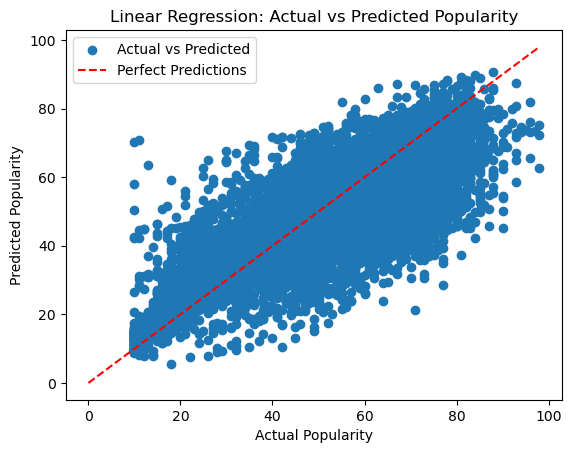

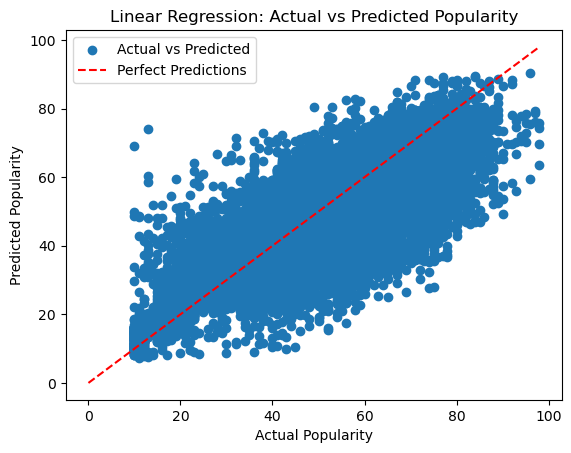

In [21]:
# Plot actual vs predicted values
plt.scatter(Y_test, Y_pred1, label='Actual vs Predicted')
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Linear Regression: Actual vs Predicted Popularity")

# Plot the line for perfect predictions
max_val = max(max(Y_test), max(Y_pred1))
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Perfect Predictions')

plt.legend()
plt.show()

# Plot actual vs predicted values
plt.scatter(Y_train, Y_pred2, label='Actual vs Predicted')
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Linear Regression: Actual vs Predicted Popularity")

# Plot the line for perfect predictions
max_val = max(max(Y_train), max(Y_pred2))
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Perfect Predictions')

plt.legend()
plt.show()

The parameters for the Random Forest and Ridge Regression
Model was created using the GridSearch method, which uses cross validation and a variety of parameter choices defined in a matrix to compute the optimal model. 

In [28]:
# Define a Ridge regression model with regularization
ridge = Ridge(alpha=1000.0)  # Using the best alpha value found during hyperparameter tuning

# Fit the model to the training data
ridge.fit(X_train_scaled, Y_train)

Ridge(alpha=1000.0)

In [29]:
# Predict popularity scores on the test set
Y_pred_1 = ridge.predict(X_test_scaled)

Y_pred_2 = ridge.predict(X_train_scaled)

R-squared (Test): 0.6558979699811396
R-squared (Training): 0.6613159123310309
Mean Squared Error(Test): 101.43114810167147
Mean Squared Error(Training): 98.72828315608614
Mean Absolute Error(Test): 7.397868082966185
Mean Absolute Error(Training): 7.353408403394579


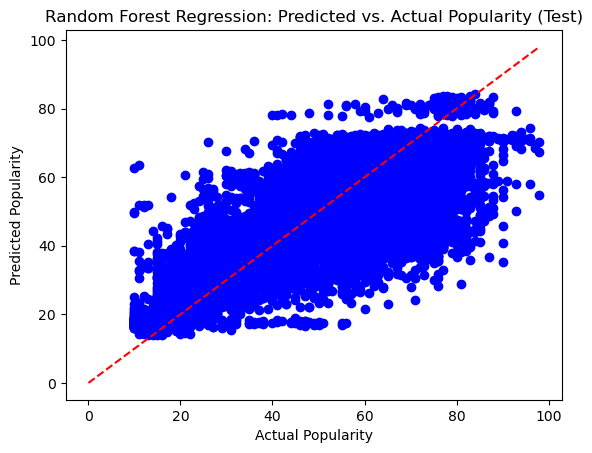

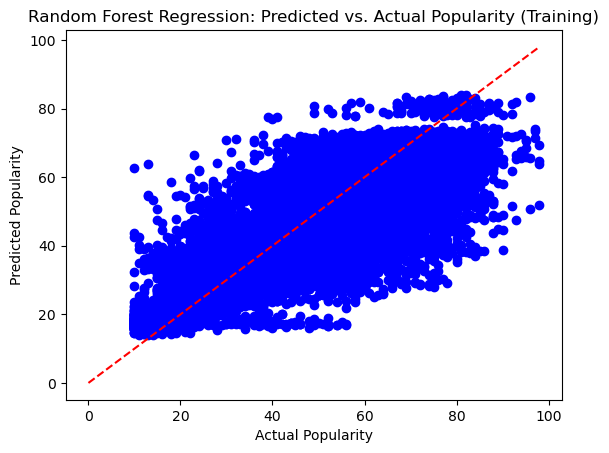

In [30]:
# Calculate R^2 score
r2_r1 = r2_score(Y_test, Y_pred_1)
print("R-squared (Test):", r2_r1)

r2_r2 = r2_score(Y_train, Y_pred_2)
print("R-squared (Training):", r2_r2)

# Calculate mean squared error
mse_r1 = mean_squared_error(Y_test, Y_pred_1)
print("Mean Squared Error(Test):", mse_r1)

mse_r2 = mean_squared_error(Y_train, Y_pred_2)
print("Mean Squared Error(Training):", mse_r2)

# Calculate mean absolute error
mae_r1 = mean_absolute_error(Y_test, Y_pred_1)
print("Mean Absolute Error(Test):", mae_r1)

mae_r2 = mean_absolute_error(Y_train, Y_pred_2)
print("Mean Absolute Error(Training):", mae_r2)

# Plot predicted vs. actual values
plt.scatter(Y_test, Y_pred_1, color='blue')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Random Forest Regression: Predicted vs. Actual Popularity (Test)')
# Plot the line for perfect predictions
max_val = max(max(Y_test), max(Y_pred_1))
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Perfect Predictions')
plt.show()

# Plot predicted vs. actual values
plt.scatter(Y_train, Y_pred_2, color='blue')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Random Forest Regression: Predicted vs. Actual Popularity (Training)')
# Plot the line for perfect predictions
max_val = max(max(Y_train), max(Y_pred_2))
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Perfect Predictions')
plt.show()

In [22]:
# Define Random Forest regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)

# Train the Random Forest model
rf.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [24]:
# Predict popularity scores on the test set
Y_pred3 = rf.predict(X_test)

# Predict popularity scores on the training set
Y_pred4 = rf.predict(X_train)

R-squared (Test): 0.7864176620789796
R-squared (Training): 0.9703196802545279
Mean Squared Error(Test): 62.95778536494207
Mean Squared Error(Training): 8.651977222083794
Mean Absolute Error(Test): 4.909321907202733
Mean Absolute Error(Training): 1.8286886412985441


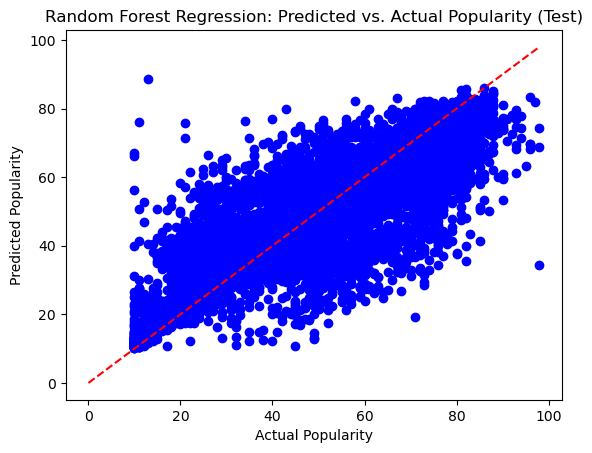

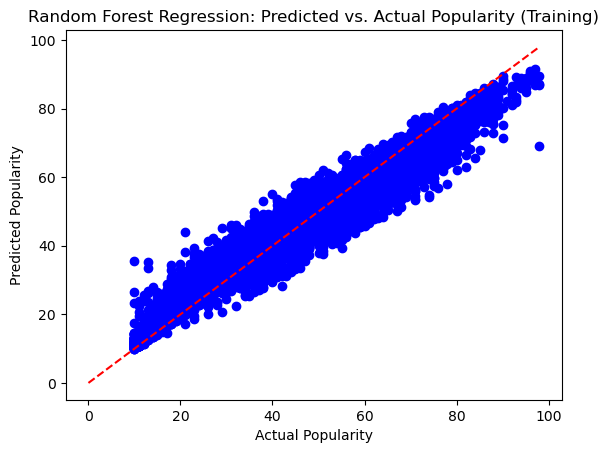

In [31]:
# Calculate R^2 score
r2_1 = r2_score(Y_test, Y_pred3)
print("R-squared (Test):", r2_1)

r2_2 = r2_score(Y_train, Y_pred4)
print("R-squared (Training):", r2_2)

# Calculate mean squared error
mse_1 = mean_squared_error(Y_test, Y_pred3)
print("Mean Squared Error(Test):", mse_1)

mse_2 = mean_squared_error(Y_train, Y_pred4)
print("Mean Squared Error(Training):", mse_2)

# Calculate mean absolute error
mae_1 = mean_absolute_error(Y_test, Y_pred3)
print("Mean Absolute Error(Test):", mae_1)

mae_2 = mean_absolute_error(Y_train, Y_pred4)
print("Mean Absolute Error(Training):", mae_2)

# Plot predicted vs. actual values
plt.scatter(Y_test, Y_pred3, color='blue')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Random Forest Regression: Predicted vs. Actual Popularity (Test)')
# Plot the line for perfect predictions
max_val = max(max(Y_test), max(Y_pred3))
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Perfect Predictions')
plt.show()

# Plot predicted vs. actual values
plt.scatter(Y_train, Y_pred4, color='blue')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Random Forest Regression: Predicted vs. Actual Popularity (Training)')
# Plot the line for perfect predictions
max_val = max(max(Y_train), max(Y_pred4))
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Perfect Predictions')
plt.show()

In [32]:
dump(linear_regressor, 'modified_linear.joblib')

['modified_linear.joblib']

In [33]:
dump(ridge, 'modified_ridge.joblib')

['modified_ridge.joblib']

In [34]:
dump(rf, 'modified_randomforest.joblib')

['modified_randomforest.joblib']

#### Among the 3 models we've implemented, Random Forest has performed the best, with an R2 score of 78.64%. The hyperparameters were obtained through a gridsearch for both Ridge and Random Forest, but further optimisations can be done through eliminating collinearity if present, and other data optimizations